In [1]:
# pip installs - ignore the error message!

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3    datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib
!pip install --upgrade transformers==4.49.0 accelerate bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 974.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt


In [3]:
# Free and public models for tokenizer testing
GPT2_SMALL = "gpt2"
OPEN_LLAMA_3B = "openlm-research/open_llama_3b"
BLOOM_560M = "bigscience/bloom-560m"
FALCON_7B = "tiiuae/falcon-7b"

# Set base model (you will choose after investigating)
BASE_MODEL = GPT2_SMALL

# Dataset information
HF_USER = "ed-donner"  # Change if using your own dataset
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Colors for output
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red": RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline


In [4]:
# Log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)


In [5]:
def investigate_tokenizer(model_name):
    print("Investigating tokenizer for", model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    for number in [0, 1, 10, 100, 999, 1000]:
        tokens = tokenizer.encode(str(number), add_special_tokens=False)
        print(f"The tokens for {number}: {tokens}")




In [6]:
# Try with each model
investigate_tokenizer(GPT2_SMALL)



Investigating tokenizer for gpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [940]
The tokens for 100: [3064]
The tokens for 999: [17032]
The tokens for 1000: [12825]


In [7]:
investigate_tokenizer(OPEN_LLAMA_3B)


Investigating tokenizer for openlm-research/open_llama_3b


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

The tokens for 0: [31822, 31852]
The tokens for 1: [31822, 31853]
The tokens for 10: [31822, 31853, 31852]
The tokens for 100: [31822, 31853, 31852, 31852]
The tokens for 999: [31822, 31877, 31877, 31877]
The tokens for 1000: [31822, 31853, 31852, 31852, 31852]


In [8]:
investigate_tokenizer(BLOOM_560M)


Investigating tokenizer for bigscience/bloom-560m


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

The tokens for 0: [19]
The tokens for 1: [20]
The tokens for 10: [1416]
The tokens for 100: [5698]
The tokens for 999: [48477]
The tokens for 1000: [25052]


In [9]:
investigate_tokenizer(FALCON_7B)

Investigating tokenizer for tiiuae/falcon-7b


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

The tokens for 0: [27]
The tokens for 1: [28]
The tokens for 10: [696]
The tokens for 100: [1425]
The tokens for 999: [15845]
The tokens for 1000: [1425, 27]


✅ Choose: Falcon‑7B (tiiuae/falcon-7b)

Reasoning:

Good numeric handling — most prices will be 1 token or 2 tokens max.

Modern architecture & tokenizer trained on recent large-scale data.

Open access, no gating.

Balanced performance vs. memory requirements (better than BLOOM-560M for English-centric tasks).

In [10]:

BASE_MODEL = FALCON_7B  # <-- Change this after observation
print(f"Selected base model: {BASE_MODEL}")


Selected base model: tiiuae/falcon-7b


In [11]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

test[0]


README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

In [12]:
# Set up quantization
if QUANT_4_BIT:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"
    )
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

Memory footprint: 3.9 GB


In [14]:
def extract_price(s):
    if "Price is $" in s:
        contents = s.split("Price is $")[1]
        contents = contents.replace(',', '').replace('$', '')
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
        return float(match.group()) if match else 0
    return 0

# Test the function
extract_price("Price is $999 blah blah so cheap")


999.0

In [16]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(
        inputs,
        max_new_tokens=4,
        attention_mask=attention_mask,
        num_return_sequences=1
    )
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

# Test on one example
model_predict(test[1]['text'])


29.99

In [18]:
class Tester:
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses, self.truths, self.errors, self.sles, self.colors = [], [], [], [], []

    def color_for(self, error, truth):
        if error < 40 or error/truth < 0.2:
            return "green"
        elif error < 80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."

        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)

        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()


1: Guess: $0.00 Truth: $374.41 Error: $374.41 SLE: 35.14 Item: OEM AC Compressor w/...
2: Guess: $29.99 Truth: $225.11 Error: $195.12 SLE: 3.95 Item: Motorcraft YB3125 Fa...
3: Guess: $20.00 Truth: $61.68 Error: $41.68 SLE: 1.20 Item: Dorman Front Washer ...
4: Guess: $0.00 Truth: $599.99 Error: $599.99 SLE: 40.94 Item: HP Premium HD Plus T...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: Super Switch Pickup ...
6: Guess: $9.99 Truth: $31.99 Error: $22.00 SLE: 1.21 Item: Horror Bookmarks, Re...
7: Guess: $19.99 Truth: $101.79 Error: $81.80 SLE: 2.52 Item: SK6241 - Stinger 4 G...
8: Guess: $199.00 Truth: $289.00 Error: $90.00 SLE: 0.14 Item: Godox ML60Bi LED Lig...
9: Guess: $1,000.00 Truth: $635.86 Error: $364.14 SLE: 0.20 Item: Randall G3 Plus Comb...
10: Guess: $20.99 Truth: $65.99 Error: $45.00 SLE: 1.24 Item: HOLDWILL 6 Pack LED ...
11: Guess: $199.99 Truth: $254.21 Error: $54.22 SLE: 0.06 Item: Viking Horns 3 Gallo...
12: Guess: $0.00 Truth: $412.99 Error: $412.99 S

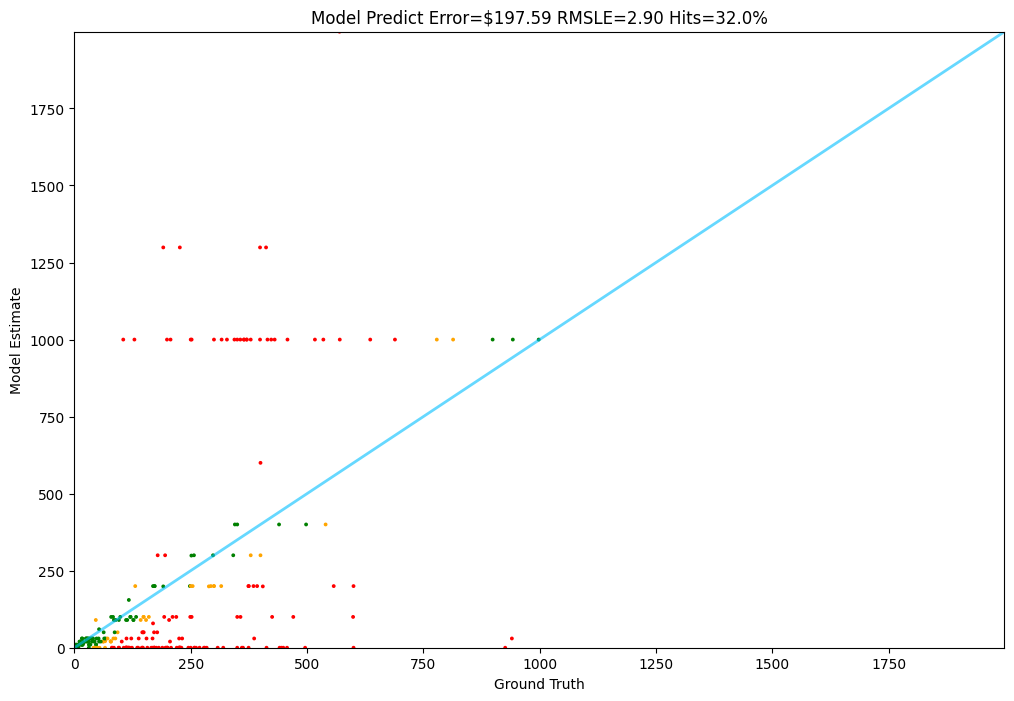

In [19]:
Tester.test(model_predict, test)
